Found 21743 files belonging to 17 classes.
Found 5437 files belonging to 17 classes.
Confusion Matrix:
[[280  38   0   1   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [ 34 279   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 319   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   6   0 314   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 280   9  16   0   1   0   0   0   3   8   3   0   0]
 [  0   0   1   1  20 267  21   0   0   0   0   0   1   3   3   0   3]
 [  0   0   0   1  23  14 271   0   1   0   0   0   0   8   2   0   0]
 [  0   0   0   0   0   0   0 320   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 317   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 320   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 320   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 320   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0

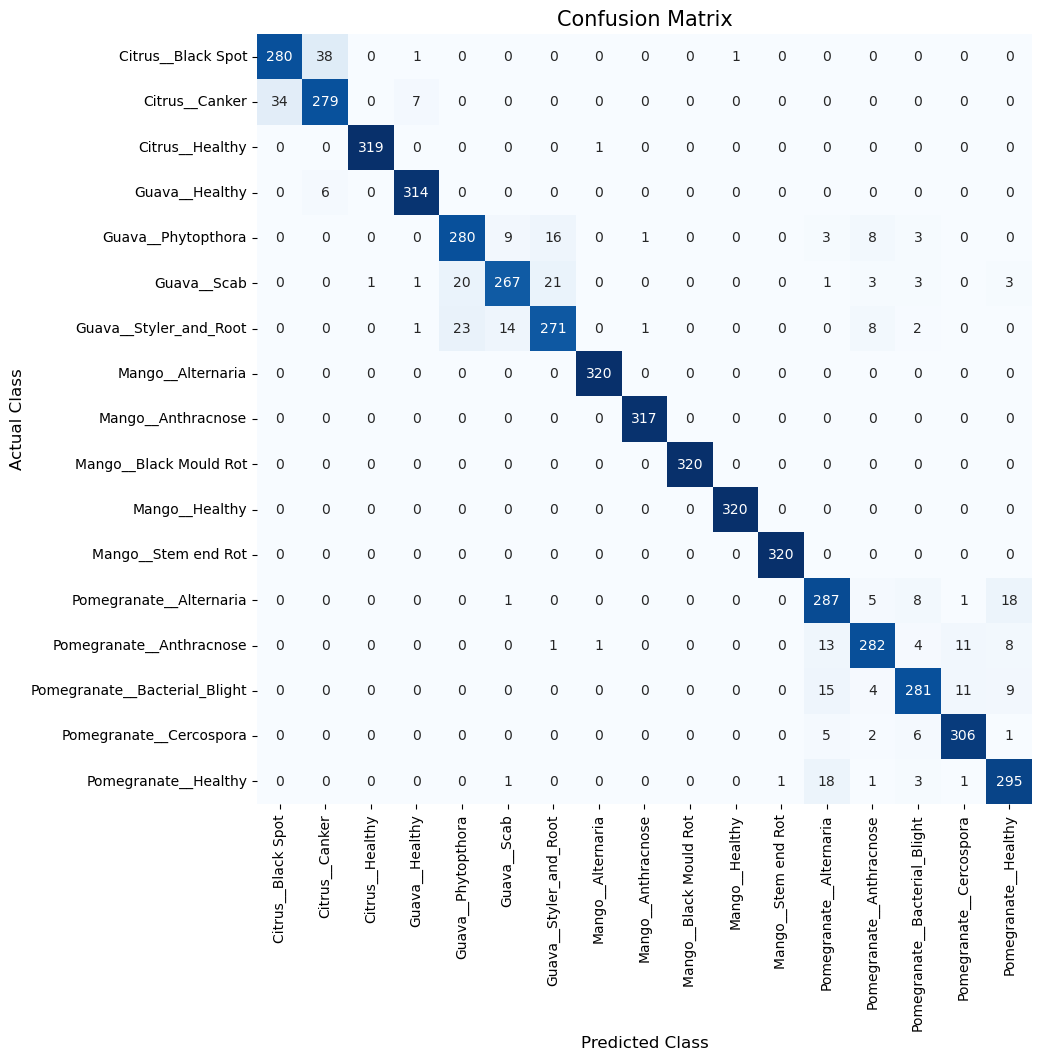

['scaler_model.pkl']

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load training and validation datasets
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),  # Changed to (128, 128)
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),  # Changed to (128, 128)
    shuffle=True,
    seed=None,
    interpolation="bilinear"
)

# Load pre-trained model for feature extraction with adjusted input size
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

# Extract features from dataset
def extract_features(dataset):
    """Extract features using the pre-trained feature extractor."""
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(feature_extractor(images).numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(training_set)
X_val, y_val = extract_features(validation_set)

# Dimensionality reduction with PCA (reduce components to speed up)
pca = PCA(n_components=30)  # Reduced from 50 to 30 for faster execution
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_val_scaled = scaler.transform(X_val_pca)

# Hyperparameter tuning for Random Forest (reduce parameter space)
param_grid = {
    'n_estimators': [50, 100],  # Reduced number of trees to speed up
    'max_depth': [10, 20],      # Removed max_depth=30 to reduce search space
    'min_samples_split': [2, 5] # Reduced range of values
}

# Use GridSearchCV with parallel processing (n_jobs=-1) and fewer CV folds (cv=3)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_val_scaled)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)

# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the trained Random Forest model
joblib.dump(best_rf, 'trained_plant_disease_rf_model.pkl')

# Save PCA and scaler
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(scaler, 'scaler_model.pkl')


                               precision    recall  f1-score   support

           Citrus__Black Spot       0.89      0.88      0.88       320
               Citrus__Canker       0.86      0.87      0.87       320
              Citrus__Healthy       1.00      1.00      1.00       320
               Guava__Healthy       0.97      0.98      0.98       320
           Guava__Phytopthora       0.87      0.88      0.87       320
                  Guava__Scab       0.91      0.83      0.87       320
       Guava__Styler_and_Root       0.88      0.85      0.86       320
            Mango__Alternaria       0.99      1.00      1.00       320
           Mango__Anthracnose       0.99      1.00      1.00       317
       Mango__Black Mould Rot       1.00      1.00      1.00       320
               Mango__Healthy       1.00      1.00      1.00       320
          Mango__Stem end Rot       1.00      1.00      1.00       320
      Pomegranate__Alternaria       0.84      0.90      0.87       320
     

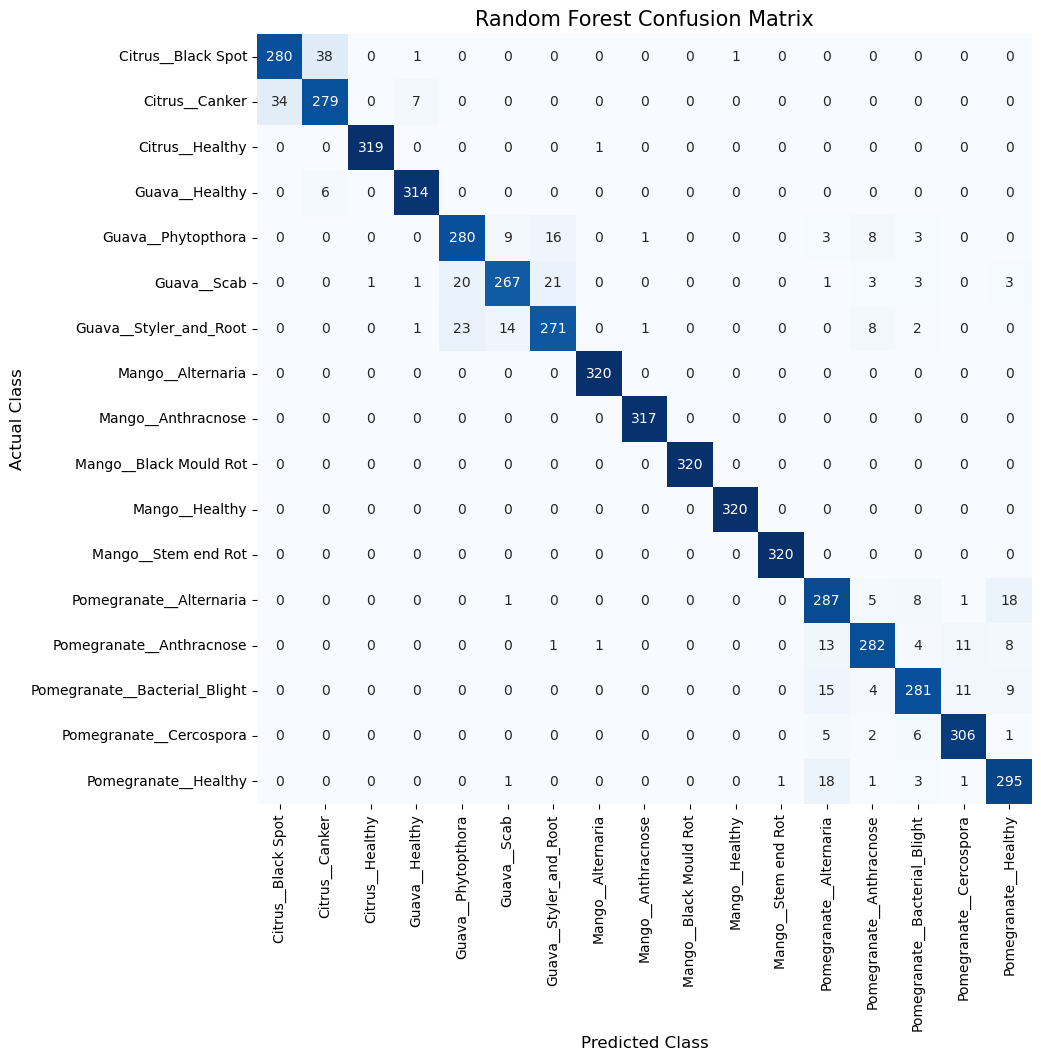

In [2]:
# Print precision, recall, f1-score
class_names = training_set.class_names
print(classification_report(y_val, y_pred, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.title('Random Forest Confusion Matrix', fontsize=15)
plt.savefig('./image/confusion_matrix_plot.png', dpi=300, bbox_inches='tight')
plt.show()